<a href="https://colab.research.google.com/github/JRM01/NNA-VS-FEniCs-FEM-/blob/main/SS_PDE_Heat_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Librerias
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Reshape
from keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np
import time
import psutil
import os

In [ ]:
Time_execution =[]

# Redes neuronales para resolver la ecuación de calor

---
$$\frac{\partial u }{\partial t}=\frac{\partial^2 u}{\partial x^2},\quad in\quad \Omega 𝗫(0,T]= \Omega_T$$$$, \quad u=u_D \quad on \quad ∂Ω𝗫(0,T]$$$$u=u_0 \quad in\quad t=0$$

---



In [ ]:
inicio = time.time()
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        #batch_size=tf.shape(data)[0]
        batch_size=100

        x = tf.random.uniform((batch_size,1), minval=0, maxval=10)
        t = tf.random.uniform((batch_size,1), minval=0, maxval=15)


        with tf.GradientTape() as tape:
            #Loss value
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(t)

                with tf.GradientTape() as gg:
                    gg.watch(x)
                    input = tf.concat((x,t),axis=1)
                    y_pred = self(input, training=True)

                y_x=gg.gradient(y_pred,x)
                #y_boundary = gg.gradient(y_pred,x0)
            y_xx=g.gradient(y_x,x)
            y_t=g.gradient(y_pred,t)


            pde = y_t - 0.5*y_xx

            t_init = tf.zeros(x.shape)
            input_ini = tf.concat((x,t_init),axis=1)
            y_init = self(input_ini, training=True)
            loss = self.mse(0., pde) + self.mse(tf.math.sin(x),y_init)

        # Compute grad
        grads = tape.gradient(loss, self.trainable_variables)

        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [ ]:
model = PDESolver()
model.add(Dense(100, activation='tanh', input_shape=(2,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
#model.add(Reshape(()))
model.summary()

Model: "pde_solver_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 100)               300       
                                                                 
 dense_62 (Dense)            (None, 10)                1010      
                                                                 
 dense_63 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam")

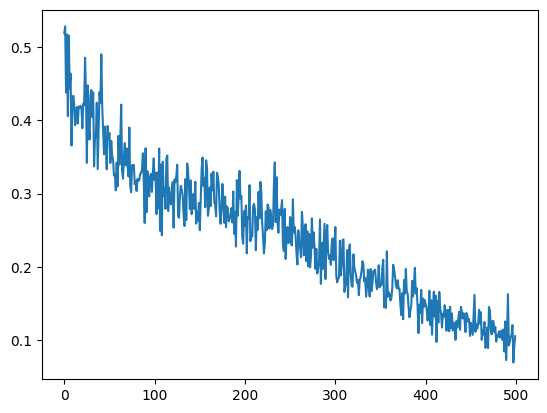

In [ ]:
x = tf.random.uniform((10,1), minval=0, maxval=10)
t = tf.random.uniform((10,1),minval=0,maxval=15)
input = tf.concat((x,t),axis=1)
history = model.fit(input,epochs=500,verbose=0)
plt.plot(history.history["loss"])

In [ ]:
nx=10*2
nt=10*2
x = np.linspace(0,1,nx)
t = np.linspace(0,2,nt)
x,t = np.meshgrid(x,t)

X =np.expand_dims(x.flatten(), axis=1)
T = np.expand_dims(t.flatten(), axis=1)
input = np.concatenate((X,T), axis=1)

In [ ]:
z = model.predict(input)

13/13 [==============================] - 0s 2ms/step


In [ ]:
z=np.reshape(z,x.shape)

Tiempo de ejecución:  5.893383502960205 seg
Uso de memoria: 1102.49 MB


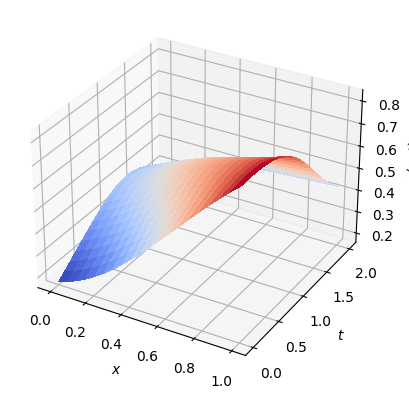

In [ ]:
#Graficamos los resultados
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, t, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('$t$')
ax.set_xlabel('$x$')
ax.set_zlabel('$p(x,t)$')

fin = time.time()
print("Tiempo de ejecución: ",fin-inicio, "seg")
Time_execution.append(fin-inicio)

# Uso de la memoria
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
print(f"Uso de memoria: {mem_info.rss / (1024 ** 2):.2f} MB")

# 2D espaciales y 1D temporal
$$\frac{\partial u }{\partial t}=(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}),\quad in\quad \Omega 𝗫(0,T]= \Omega_T$$$$, \quad u=u_D \quad on \quad ∂Ω𝗫(0,T]$$$$u=u_0 \quad in\quad t=0$$

Model: "pde_solver2d_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 200)               800       
                                                                 
 dense_58 (Dense)            (None, 10)                2010      
                                                                 
 dense_59 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2821 (11.02 KB)
Trainable params: 2821 (11.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
250/250 [==============================] - 0s 2ms/step


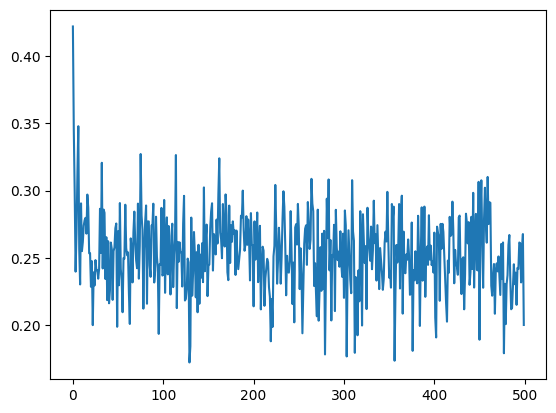

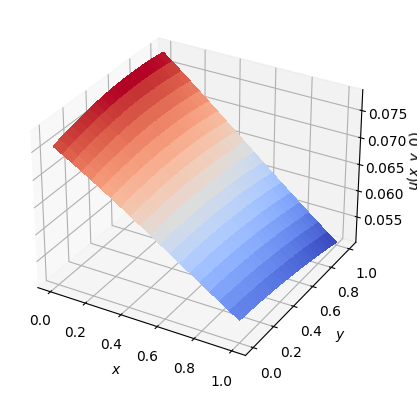

Tiempo de ejecución:  8.229799509048462 seg
Uso de memoria: 1076.95 MB


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Reshape
from keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

inicio = time.time()
class PDESolver2D(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        batch_size = 100

        x = tf.random.uniform((batch_size, 1), minval=0, maxval=10)
        y = tf.random.uniform((batch_size, 1), minval=0, maxval=10)
        t = tf.random.uniform((batch_size, 1), minval=0, maxval=15)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)
                g.watch(t)

                with tf.GradientTape(persistent=True) as gg:
                    gg.watch(x)
                    gg.watch(y)
                    input = tf.concat([x, y, t], axis=1)
                    y_pred = self(input, training=True)

                y_x = gg.gradient(y_pred, x)
                y_y = gg.gradient(y_pred, y)

            y_xx = g.gradient(y_x, x)
            y_yy = g.gradient(y_y, y)
            y_t = g.gradient(y_pred, t)

            pde = y_t - (y_xx + y_yy)

            t_init = tf.zeros_like(t)
            input_ini = tf.concat([x, y, t_init], axis=1)
            y_init = self(input_ini, training=True)
            init_condition = tf.math.sin(np.pi * x) * tf.math.sin(np.pi * y)
            loss = self.mse(0., pde) + self.mse(init_condition, y_init)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver2D()
model.add(Dense(200, activation='tanh', input_shape=(3,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer="adam")

x = tf.random.uniform((10,1), minval=0, maxval=10)
y = tf.random.uniform((10,1), minval=0, maxval=10)
t = tf.random.uniform((10,1),minval=0,maxval=15)
input = tf.concat((x,y),axis=1)
input = tf.concat((input,t),axis=1)
history = model.fit(input, epochs=500, verbose=0)
plt.plot(history.history["loss"])

nx = 20
ny = 20
nt = 20
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
t_vals = np.linspace(0, 15, nt)

X, Y, T = np.meshgrid(x_vals, y_vals, t_vals)
X_flat = X.flatten()
Y_flat = Y.flatten()
T_flat = T.flatten()

input = np.vstack([X_flat, Y_flat, T_flat]).T
z = model.predict(input)
Z = z.reshape((nx, ny, nt))

# Graficamos los resultados
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X[:, :, 0], Y[:, :, 0], Z[:, :, 0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('$y$')
ax.set_xlabel('$x$')
ax.set_zlabel('$u(x,y,0)$')
plt.show()

fin = time.time()
print("Tiempo de ejecución: ",fin-inicio, "seg")
Time_execution.append(fin-inicio)

# Uso de la memoria
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
print(f"Uso de memoria: {mem_info.rss / (1024 ** 2):.2f} MB")

# 3D espaciales y 1D temporal
$$\frac{\partial u }{\partial t}=(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}+\frac{\partial^2 u}{\partial z^2}),\quad in\quad \Omega 𝗫(0,T]= \Omega_T$$$$, \quad u=u_D \quad on \quad ∂Ω𝗫(0,T]$$$$u=u_0 \quad in\quad t=0$$

Model: "pde_solver3d_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 300)               1500      
                                                                 
 dense_34 (Dense)            (None, 30)                9030      
                                                                 
 dense_35 (Dense)            (None, 1)                 31        
                                                                 
Total params: 10561 (41.25 KB)
Trainable params: 10561 (41.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
250/250 [==============================] - 0s 1ms/step
Tiempo de ejecución:  12.66471529006958 seg
Uso de memoria: 978.94 MB


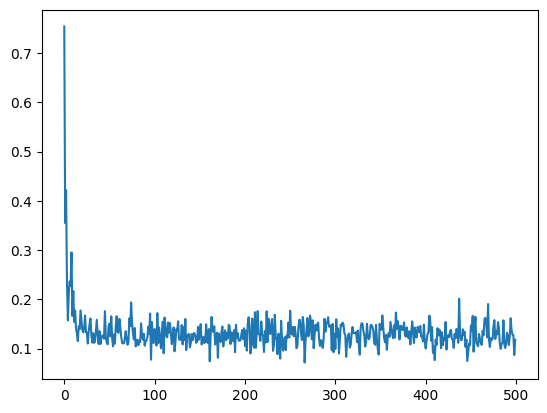

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

inicio = time.time()
class PDESolver3D(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        batch_size = 100

        x = tf.random.uniform((batch_size, 1), minval=0, maxval=10)
        y = tf.random.uniform((batch_size, 1), minval=0, maxval=10)
        z = tf.random.uniform((batch_size, 1), minval=0, maxval=10)
        t = tf.random.uniform((batch_size, 1), minval=0, maxval=15)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)
                g.watch(z)
                g.watch(t)

                with tf.GradientTape(persistent=True) as gg:
                    gg.watch(x)
                    gg.watch(y)
                    gg.watch(z)
                    input = tf.concat([x, y, z, t], axis=1)
                    y_pred = self(input, training=True)

                y_x = gg.gradient(y_pred, x)
                y_y = gg.gradient(y_pred, y)
                y_z = gg.gradient(y_pred, z)

            y_xx = g.gradient(y_x, x)
            y_yy = g.gradient(y_y, y)
            y_zz = g.gradient(y_z, z)
            y_t = g.gradient(y_pred, t)

            pde = y_t - (y_xx + y_yy + y_zz)

            t_init = tf.zeros_like(t)
            input_ini = tf.concat([x, y, z, t_init], axis=1)
            y_init = self(input_ini, training=True)
            init_condition = tf.math.sin(np.pi * x) * tf.math.sin(np.pi * y) * tf.math.sin(np.pi * z)
            loss = self.mse(0., pde) + self.mse(init_condition, y_init)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver3D()
model.add(Dense(300, activation='tanh', input_shape=(4,), name="primera"))
model.add(Dense(30, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer="adam")

x = tf.random.uniform((10,1), minval=0, maxval=10)
y = tf.random.uniform((10,1), minval=0, maxval=10)
z = tf.random.uniform((10,1), minval=0, maxval=10)
t = tf.random.uniform((10,1),minval=0,maxval=15)
input = tf.concat((x,y),axis=1)
input = tf.concat((input,z),axis=1)
input = tf.concat((input,t),axis=1)
history = model.fit(input, epochs=500, verbose=0)
plt.plot(history.history["loss"])

nx, ny, nz, nt = 20, 20, 20, 1
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
z_vals = np.linspace(0, 1, nz)
t_vals = np.linspace(0, 1, nt)

X, Y, Z, T = np.meshgrid(x_vals, y_vals, z_vals, t_vals)
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
T_flat = T.flatten()

input = np.vstack([X_flat, Y_flat, Z_flat, T_flat]).T
z_pred = model.predict(input)
Z_pred = z_pred.reshape((nx, ny, nz, nt))

fin = time.time()
print("Tiempo de ejecución: ",fin-inicio, "seg")
Time_execution.append(fin-inicio)

# Uso de la memoria
process = psutil.Process(os.getpid())

mem_info = process.memory_info()
print(f"Uso de memoria: {mem_info.rss / (1024 ** 2):.2f} MB")

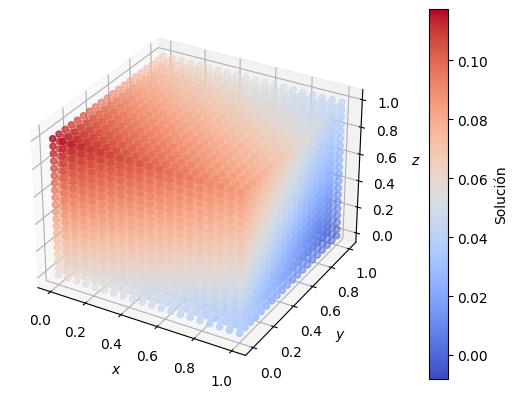

In [ ]:

# t = 0 para la visualización
t_index = 0  # índice de tiempo 0
Z_pred_t0 = Z_pred[:, :, :, t_index]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = Z_pred_t0.flatten()
scat = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=colors, cmap='coolwarm', marker='o')
cbar = plt.colorbar(scat, ax=ax, pad=0.1)
cbar.set_label('Solución')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

# 4D espaciales y 1D temporal
$$\frac{\partial u }{\partial t}=(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}+\frac{\partial^2 u}{\partial z^2}+\frac{\partial^2 u}{\partial w^2}),\quad in\quad \Omega 𝗫(0,T]= \Omega_T$$$$, \quad u=u_D \quad on \quad ∂Ω𝗫(0,T]$$$$u=u_0 \quad in\quad t=0$$

Model: "pde_solver5d_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 500)               3000      
                                                                 
 dense_20 (Dense)            (None, 10)                5010      
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 8021 (31.33 KB)
Trainable params: 8021 (31.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


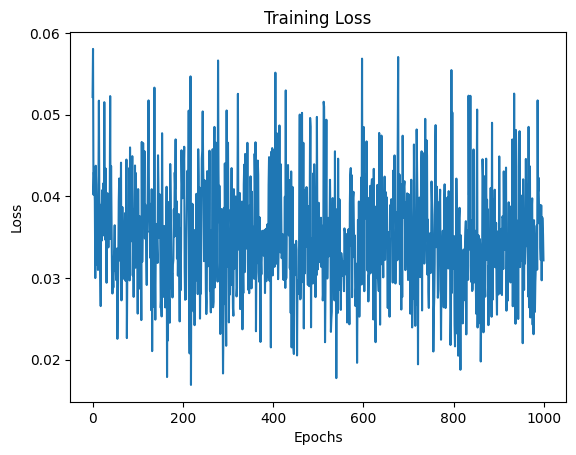

313/313 [==============================] - 1s 2ms/step


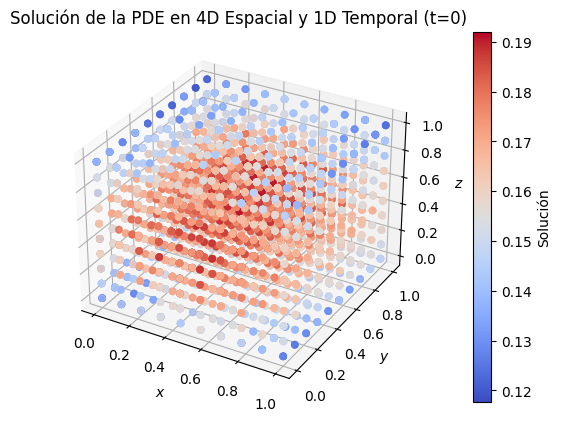

Tiempo de ejecución:  22.74382710456848 seg
Uso de memoria: 848.44 MB


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import numpy as np

inicio = time.time()
# Definición de la clase de la red neuronal para la solución de PDE
class PDESolver5D(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        batch_size = 100  # Tamaño del lote

        # Generar muestras aleatorias para x, y, z, w y t
        x = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        y = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        z = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        w = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        t = tf.random.uniform((batch_size, 1), minval=0, maxval=1)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)
                g.watch(z)
                g.watch(w)
                g.watch(t)

                with tf.GradientTape(persistent=True) as gg:
                    gg.watch(x)
                    gg.watch(y)
                    gg.watch(z)
                    gg.watch(w)
                    input = tf.concat([x, y, z, w, t], axis=1)
                    y_pred = self(input, training=True)  # Predicción de la red

                # Cálculo de las derivadas
                y_x = gg.gradient(y_pred, x)
                y_y = gg.gradient(y_pred, y)
                y_z = gg.gradient(y_pred, z)
                y_w = gg.gradient(y_pred, w)

            # Cálculo de las derivadas segundas
            y_xx = g.gradient(y_x, x)
            y_yy = g.gradient(y_y, y)
            y_zz = g.gradient(y_z, z)
            y_ww = g.gradient(y_w, w)
            y_t = g.gradient(y_pred, t)

            # Definición de la PDE
            pde = y_t - (y_xx + y_yy + y_zz + y_ww)

            # Condición inicial (por ejemplo, un producto seno)
            t_init = tf.zeros_like(t)
            input_ini = tf.concat([x, y, z, w, t_init], axis=1)
            y_init = self(input_ini, training=True)
            init_condition = tf.math.sin(np.pi * x) * tf.math.sin(np.pi * y) * \
                             tf.math.sin(np.pi * z) * tf.math.sin(np.pi * w)
            loss = self.mse(0., pde) + self.mse(init_condition, y_init)  # Función de pérdida

        # Calcular los gradientes
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))  # Actualizar pesos

        # Actualizar la métrica de pérdida
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# Crear y compilar el modelo
model = PDESolver5D()
model.add(Dense(500, activation='tanh', input_shape=(5,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer="adam")

x = tf.random.uniform((10,1), minval=0, maxval=1)
y = tf.random.uniform((10,1), minval=0, maxval=1)
z = tf.random.uniform((10,1), minval=0, maxval=1)
w = tf.random.uniform((10,1), minval=0, maxval=1)
t = tf.random.uniform((10,1),minval=0,maxval=1)
input = tf.concat((x,y), axis=1)
input = tf.concat((input,z), axis=1)
input = tf.concat((input,w), axis=1)
input = tf.concat((input,t), axis=1)
history = model.fit(input, epochs=1000, verbose=0)
plt.plot(history.history["loss"])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Configurar el espacio para la predicción
nx, ny, nz, nw, nt = 10, 10, 10, 10, 1
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
z_vals = np.linspace(0, 1, nz)
w_vals = np.linspace(0, 1, nw)
t_vals = np.linspace(0, 1, nt)

X, Y, Z, W, T = np.meshgrid(x_vals, y_vals, z_vals, w_vals, t_vals)
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
W_flat = W.flatten()
T_flat = T.flatten()

input = np.vstack([X_flat, Y_flat, Z_flat, W_flat, T_flat]).T
z_pred = model.predict(input)  # Predicción del modelo
Z_pred = z_pred.reshape((nx, ny, nz, nw, nt))

# Seleccionar t = 0 para la visualización
t_index = 0  # Seleccionar el índice de tiempo 0
Z_pred_t0 = Z_pred[:, :, :, :, t_index]

# Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crear una lista de colores basada en los valores de Z_pred_t0
colors = Z_pred_t0.flatten()

# Graficar los puntos en el cubo de 1x1x1
scat = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=colors, cmap='coolwarm', marker='o')

# Añadir la barra de color
cbar = plt.colorbar(scat, ax=ax, pad=0.1)
cbar.set_label('Solución')

# Configuración de etiquetas de los ejes
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Solución de la PDE en 4D Espacial y 1D Temporal (t=0)')

plt.show()
fin = time.time()
print("Tiempo de ejecución: ",fin-inicio, "seg")
Time_execution.append(fin-inicio)


# Uso de la memoria
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
print(f"Uso de memoria: {mem_info.rss / (1024 ** 2):.2f} MB")

# 5D espaciales y 1D temporal
$$\frac{\partial u }{\partial t}=(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}+\frac{\partial^2 u}{\partial z^2}+\frac{\partial^2 u}{\partial w^2}+\frac{\partial^2 u}{\partial v^2}),\quad in\quad \Omega 𝗫(0,T]= \Omega_T$$$$, \quad u=u_D \quad on \quad ∂Ω𝗫(0,T]$$$$u=u_0 \quad in\quad t=0$$

Model: "pde_solver6d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 600)               4200      
                                                                 
 dense_32 (Dense)            (None, 60)                36060     
                                                                 
 dense_33 (Dense)            (None, 1)                 61        
                                                                 
Total params: 40321 (157.50 KB)
Trainable params: 40321 (157.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


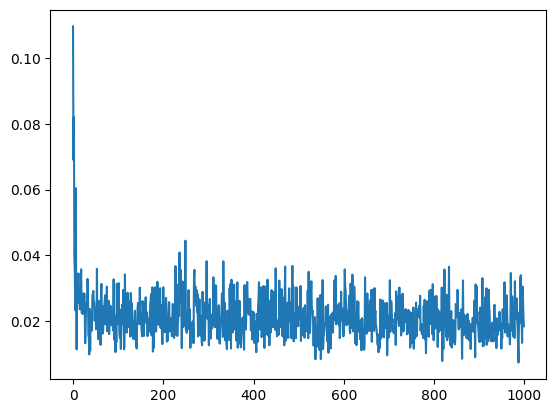

3125/3125 [==============================] - 6s 2ms/step


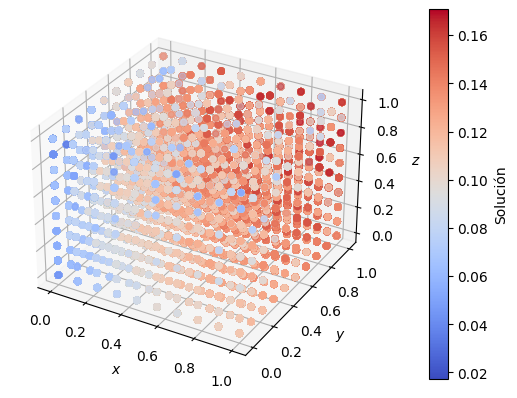

Tiempo de ejecución:  55.81329536437988 seg
Uso de memoria: 976.21 MB


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

inicio = time.time()
class PDESolver6D(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        batch_size = 100

        x = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        y = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        z = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        w = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        v = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        t = tf.random.uniform((batch_size, 1), minval=0, maxval=1)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch([x, y, z, w, v, t])

                with tf.GradientTape(persistent=True) as gg:
                    gg.watch([x, y, z, w, v])
                    input = tf.concat([x, y, z, w, v, t], axis=1)
                    y_pred = self(input, training=True)

                y_x = gg.gradient(y_pred, x)
                y_y = gg.gradient(y_pred, y)
                y_z = gg.gradient(y_pred, z)
                y_w = gg.gradient(y_pred, w)
                y_v = gg.gradient(y_pred, v)

            y_xx = g.gradient(y_x, x)
            y_yy = g.gradient(y_y, y)
            y_zz = g.gradient(y_z, z)
            y_ww = g.gradient(y_w, w)
            y_vv = g.gradient(y_v, v)
            y_t = g.gradient(y_pred, t)

            pde = y_t - (y_xx + y_yy + y_zz + y_ww + y_vv)

            t_init = tf.zeros_like(t)
            input_ini = tf.concat([x, y, z, w, v, t_init], axis=1)
            y_init = self(input_ini, training=True)
            init_condition = tf.math.sin(np.pi * x) * tf.math.sin(np.pi * y) * tf.math.sin(np.pi * z) * tf.math.sin(np.pi * w) * tf.math.sin(np.pi * v)
            loss = self.mse(0., pde) + self.mse(init_condition, y_init)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver6D()
model.add(Dense(600, activation='tanh', input_shape=(6,), name="primera"))
model.add(Dense(60, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer="adam")


x = tf.random.uniform((10,1), minval=0, maxval=10)
y = tf.random.uniform((10,1), minval=0, maxval=10)
z = tf.random.uniform((10,1), minval=0, maxval=10)
w = tf.random.uniform((10,1), minval=0, maxval=10)
v = tf.random.uniform((10,1), minval=0, maxval=10)
t = tf.random.uniform((10,1),minval=0,maxval=15)
input = tf.concat((x,y),axis=1)
input = tf.concat((input,z),axis=1)
input = tf.concat((input,w),axis=1)
input = tf.concat((input,v),axis=1)
input = tf.concat((input,t),axis=1)
history = model.fit(input, epochs=1000, verbose=0)
plt.plot(history.history["loss"])
plt.show()

nx, ny, nz, nw, nv, nt = 10, 10, 10, 10, 10, 1
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
z_vals = np.linspace(0, 1, nz)
w_vals = np.linspace(0, 1, nw)
v_vals = np.linspace(0, 1, nv)
t_vals = np.linspace(0, 1, nt)

X, Y, Z, W, V, T = np.meshgrid(x_vals, y_vals, z_vals, w_vals, v_vals, t_vals)
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
W_flat = W.flatten()
V_flat = V.flatten()
T_flat = T.flatten()

input = np.vstack([X_flat, Y_flat, Z_flat, W_flat, V_flat, T_flat]).T
z_pred = model.predict(input)
Z_pred = z_pred.reshape((nx, ny, nz, nw, nv, nt))

# Seleccionamos t = 0 para la visualización
t_index = 0  # Seleccionamos el índice de tiempo 0
Z_pred_t0 = Z_pred[:, :, :, :, :, t_index]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crear una lista de colores basada en los valores de Z_pred_t0
colors = Z_pred_t0.flatten()

# Graficamos los puntos en el cubo de 1x1x1
scat = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=colors, cmap='coolwarm', marker='o')

# Añadir la barra de color
cbar = plt.colorbar(scat, ax=ax, pad=0.1)
cbar.set_label('Solución')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

fin = time.time()
print("Tiempo de ejecución: ",fin-inicio, "seg")
Time_execution.append(fin-inicio)

# Uso de la memoria
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
print(f"Uso de memoria: {mem_info.rss / (1024 ** 2):.2f} MB")


# 6D espaciales y 1D temporal
$$\frac{\partial u }{\partial t}=(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}+\frac{\partial^2 u}{\partial z^2}+\frac{\partial^2 u}{\partial w^2}+\frac{\partial^2 u}{\partial v^2}+\frac{\partial^2 u}{\partial q^2}),\quad in\quad \Omega 𝗫(0,T]= \Omega_T$$$$, \quad u=u_D \quad on \quad ∂Ω𝗫(0,T]$$$$u=u_0 \quad in\quad t=0$$

Model: "pde_solver7d_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 700)               5600      
                                                                 
 dense_22 (Dense)            (None, 70)                49070     
                                                                 
 dense_23 (Dense)            (None, 1)                 71        
                                                                 
Total params: 54741 (213.83 KB)
Trainable params: 54741 (213.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


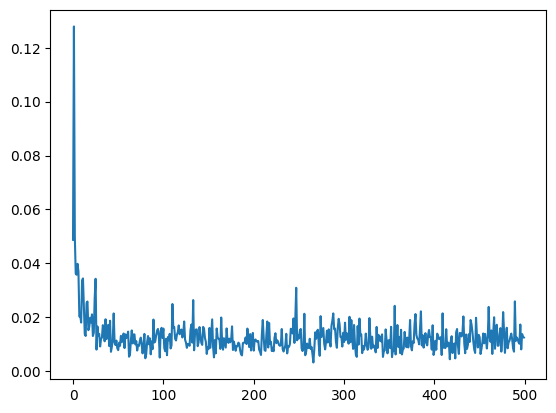

31250/31250 [==============================] - 50s 2ms/step


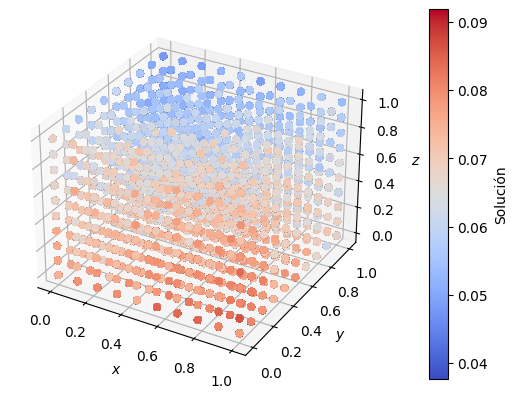

Tiempo de ejecución:  126.43405532836914 seg
Uso de memoria: 1554.58 MB


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

inicio = time.time()
class PDESolver7D(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        batch_size = 100

        x = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        y = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        z = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        w = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        v = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        u = tf.random.uniform((batch_size, 1), minval=0, maxval=1)
        t = tf.random.uniform((batch_size, 1), minval=0, maxval=1)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch([x, y, z, w, v, u, t])

                with tf.GradientTape(persistent=True) as gg:
                    gg.watch([x, y, z, w, v, u])
                    input = tf.concat([x, y, z, w, v, u, t], axis=1)
                    y_pred = self(input, training=True)

                y_x = gg.gradient(y_pred, x)
                y_y = gg.gradient(y_pred, y)
                y_z = gg.gradient(y_pred, z)
                y_w = gg.gradient(y_pred, w)
                y_v = gg.gradient(y_pred, v)
                y_u = gg.gradient(y_pred, u)

            y_xx = g.gradient(y_x, x)
            y_yy = g.gradient(y_y, y)
            y_zz = g.gradient(y_z, z)
            y_ww = g.gradient(y_w, w)
            y_vv = g.gradient(y_v, v)
            y_uu = g.gradient(y_u, u)
            y_t = g.gradient(y_pred, t)

            pde = y_t - (y_xx + y_yy + y_zz + y_ww + y_vv + y_uu)

            t_init = tf.zeros_like(t)
            input_ini = tf.concat([x, y, z, w, v, u, t_init], axis=1)
            y_init = self(input_ini, training=True)
            init_condition = tf.math.sin(np.pi * x) * tf.math.sin(np.pi * y) * tf.math.sin(np.pi * z) * tf.math.sin(np.pi * w) * tf.math.sin(np.pi * v) * tf.math.sin(np.pi * u)
            loss = self.mse(0., pde) + self.mse(init_condition, y_init)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver7D()
model.add(Dense(700, activation='tanh', input_shape=(7,), name="primera"))
model.add(Dense(70, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer="adam")
x = tf.random.uniform((10,1), minval=0, maxval=10)
y = tf.random.uniform((10,1), minval=0, maxval=10)
z = tf.random.uniform((10,1), minval=0, maxval=10)
w = tf.random.uniform((10,1), minval=0, maxval=10)
v = tf.random.uniform((10,1), minval=0, maxval=10)
u = tf.random.uniform((10,1), minval=0, maxval=10)
t = tf.random.uniform((10,1),minval=0,maxval=15)
input = tf.concat((x,y),axis=1)
input = tf.concat((input,z),axis=1)
input = tf.concat((input,w),axis=1)
input = tf.concat((input,v),axis=1)
input = tf.concat((input,u),axis=1)
input = tf.concat((input,t),axis=1)
history = model.fit(input, epochs=500, verbose=0)

plt.plot(history.history["loss"])
plt.show()

nx, ny, nz, nw, nv, nu, nt = 10, 10, 10, 10, 10, 10, 1
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
z_vals = np.linspace(0, 1, nz)
w_vals = np.linspace(0, 1, nw)
v_vals = np.linspace(0, 1, nv)
u_vals = np.linspace(0, 1, nu)
t_vals = np.linspace(0, 1, nt)

X, Y, Z, W, V, U, T = np.meshgrid(x_vals, y_vals, z_vals, w_vals, v_vals, u_vals, t_vals)
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
W_flat = W.flatten()
V_flat = V.flatten()
U_flat = U.flatten()
T_flat = T.flatten()

input = np.vstack([X_flat, Y_flat, Z_flat, W_flat, V_flat, U_flat, T_flat]).T
z_pred = model.predict(input)
Z_pred = z_pred.reshape((nx, ny, nz, nw, nv, nu, nt))

# Seleccionamos t = 0 para la visualización
t_index = 0  # Seleccionamos el índice de tiempo 0
Z_pred_t0 = Z_pred[:, :, :, :, :, :, t_index]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crear una lista de colores basada en los valores de Z_pred_t0
colors = Z_pred_t0.flatten()

# Graficamos los puntos en el cubo de 1x1x1
scat = ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=colors, cmap='coolwarm', marker='o')

# Añadir la barra de color
cbar = plt.colorbar(scat, ax=ax, pad=0.1)
cbar.set_label('Solución')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()


fin = time.time()
print("Tiempo de ejecución: ",fin-inicio, "seg")
Time_execution.append(fin-inicio)

# Uso de la memoria
process = psutil.Process(os.getpid())
mem_info = process.memory_info()
print(f"Uso de memoria: {mem_info.rss / (1024 ** 2):.2f} MB")

In [ ]:
print(Time_execution)
Dimenaions_NNA = ["1D","2D","3D","4D","5D","6D"]
Time_execution2 = [0.04378819465637207, 7.042509317398071, 7.777249097824097, 375.4634065628052, 35.79790186882019, 138.55493760108948]



[4.966799736022949, 8.248029470443726, 10.33286452293396, 20.684349536895752, 34.67561078071594, 126.43405532836914]


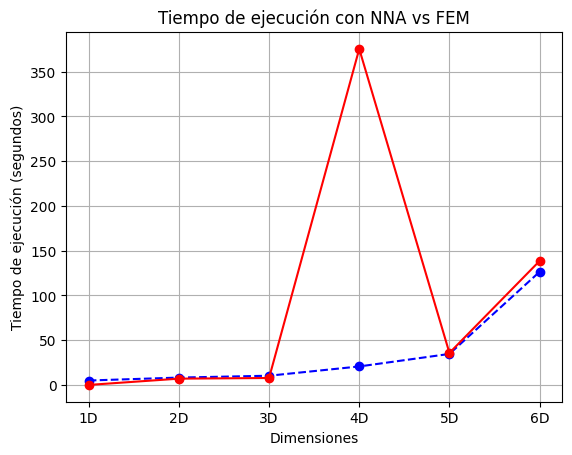

In [ ]:
plt.plot(Dimenaions_NNA,Time_execution, marker='o', linestyle='--',color='b', label='Datos')
plt.plot(Dimenaions_NNA,Time_execution2, marker='o', linestyle='-',color='r', label='Datos')

plt.xlabel('Dimensiones')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Tiempo de ejecución con NNA vs FEM')
plt.grid(True)
plt.show()

https://i.gifer.com/v5T.gif